# Versions

This was created in a Python 3.10.12 environment with PyTorch Version: 2.2.1+cu121.

# Installations

In [ ]:
# !pip3 install torch torchvision pillow matplotlib

# Imports

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

import os
import random
from PIL import Image, ImageEnhance, ImageFilter
import matplotlib.pyplot as plt

from IPython.display import Image as ImagePy
from IPython.core.display import HTML 
from collections import Counter


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Define Model Architectures

In [3]:
class BinaryCNNModel(nn.Module):
    def __init__(self):
        super(BinaryCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=3, padding='same')
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm2d(6)
        self.fc = nn.Linear(6 * 32 * 32, 1)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(x)
        x = self.bn1(self.dropout1(x))
        
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [4]:
class TwoLayerBinaryCNNModel(nn.Module):
    def __init__(self):
        super(TwoLayerBinaryCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=3, padding='same')
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(6, 12, kernel_size=3, padding='same')
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        
        self.dropout1 = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm2d(12)
        
        self.fc = nn.Linear(12 * 32 * 32, 1)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.bn1(self.dropout1(x))
        
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [5]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load our Binary Classification Models

In [13]:
def load_model(checkpoint_path, model_architecture):
    model = model_architecture().to('cuda' if torch.cuda.is_available() else 'cpu')
    checkpoint = torch.load(checkpoint_path)
    state_dict = checkpoint['state_dict']
    new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(new_state_dict)
    model.eval()
    return model

    return model


models = [
    ["exposure", load_model('checkpoints_camera_binary/exposure_13.pth', BinaryCNNModel)],
    ["cool", load_model('checkpoints_camera_binary/cool_2.pth', TwoLayerBinaryCNNModel)],
    ["cool_hue", load_model('checkpoints_camera_binary/cool_hue_1.pth', BinaryCNNModel)],
    ["warmth", load_model('checkpoints_camera_binary/warmth_2.pth', TwoLayerBinaryCNNModel)],
    ["black_and_white", load_model('checkpoints_camera_binary/black_and_white_1.pth', BinaryCNNModel)],
    ["blur", load_model('checkpoints_camera_binary/blur_2.pth', TwoLayerBinaryCNNModel)],
    ["contrast", load_model('checkpoints_camera_binary/contrast_1.pth', TwoLayerBinaryCNNModel)],
    ["sepia", load_model('checkpoints_camera_binary/sepia_1.pth', BinaryCNNModel)]
]

# Define Prediction Functions

Simple predict whether an image has a filter or not.

In [14]:
def predict_filter(input_batch):
    filter_detected = False
    for model in models:
        with torch.no_grad():
            output = model[1](input_batch)
            probs = torch.sigmoid(output)

            cutoff = 0.5
            #if model[0] == "blur": cutoff = 0.5
        
            predicted = (probs > cutoff).float()
            if predicted.item() == 1:
                filter_detected = True
                break

    return "Filter" if filter_detected else "No filter detected"
    
    #return 1 if filter_detected else 0

Show the filter with the output for the image [0,1].

In [15]:
def predict_with_filter_scores(input_batch):
    max_prob = 0.0
    max_filter = None

    for model in models:
        with torch.no_grad():
            output = model[1](input_batch)
            probs = torch.sigmoid(output)

            if probs.item() > max_prob:
                max_prob = probs.item()
                max_filter = model[0]

    if max_filter:
        return f"{max_filter} {max_prob:.2f}"
    else:
        return "No filter detected"

# Display predictions for each image

Provide a folder containing images.

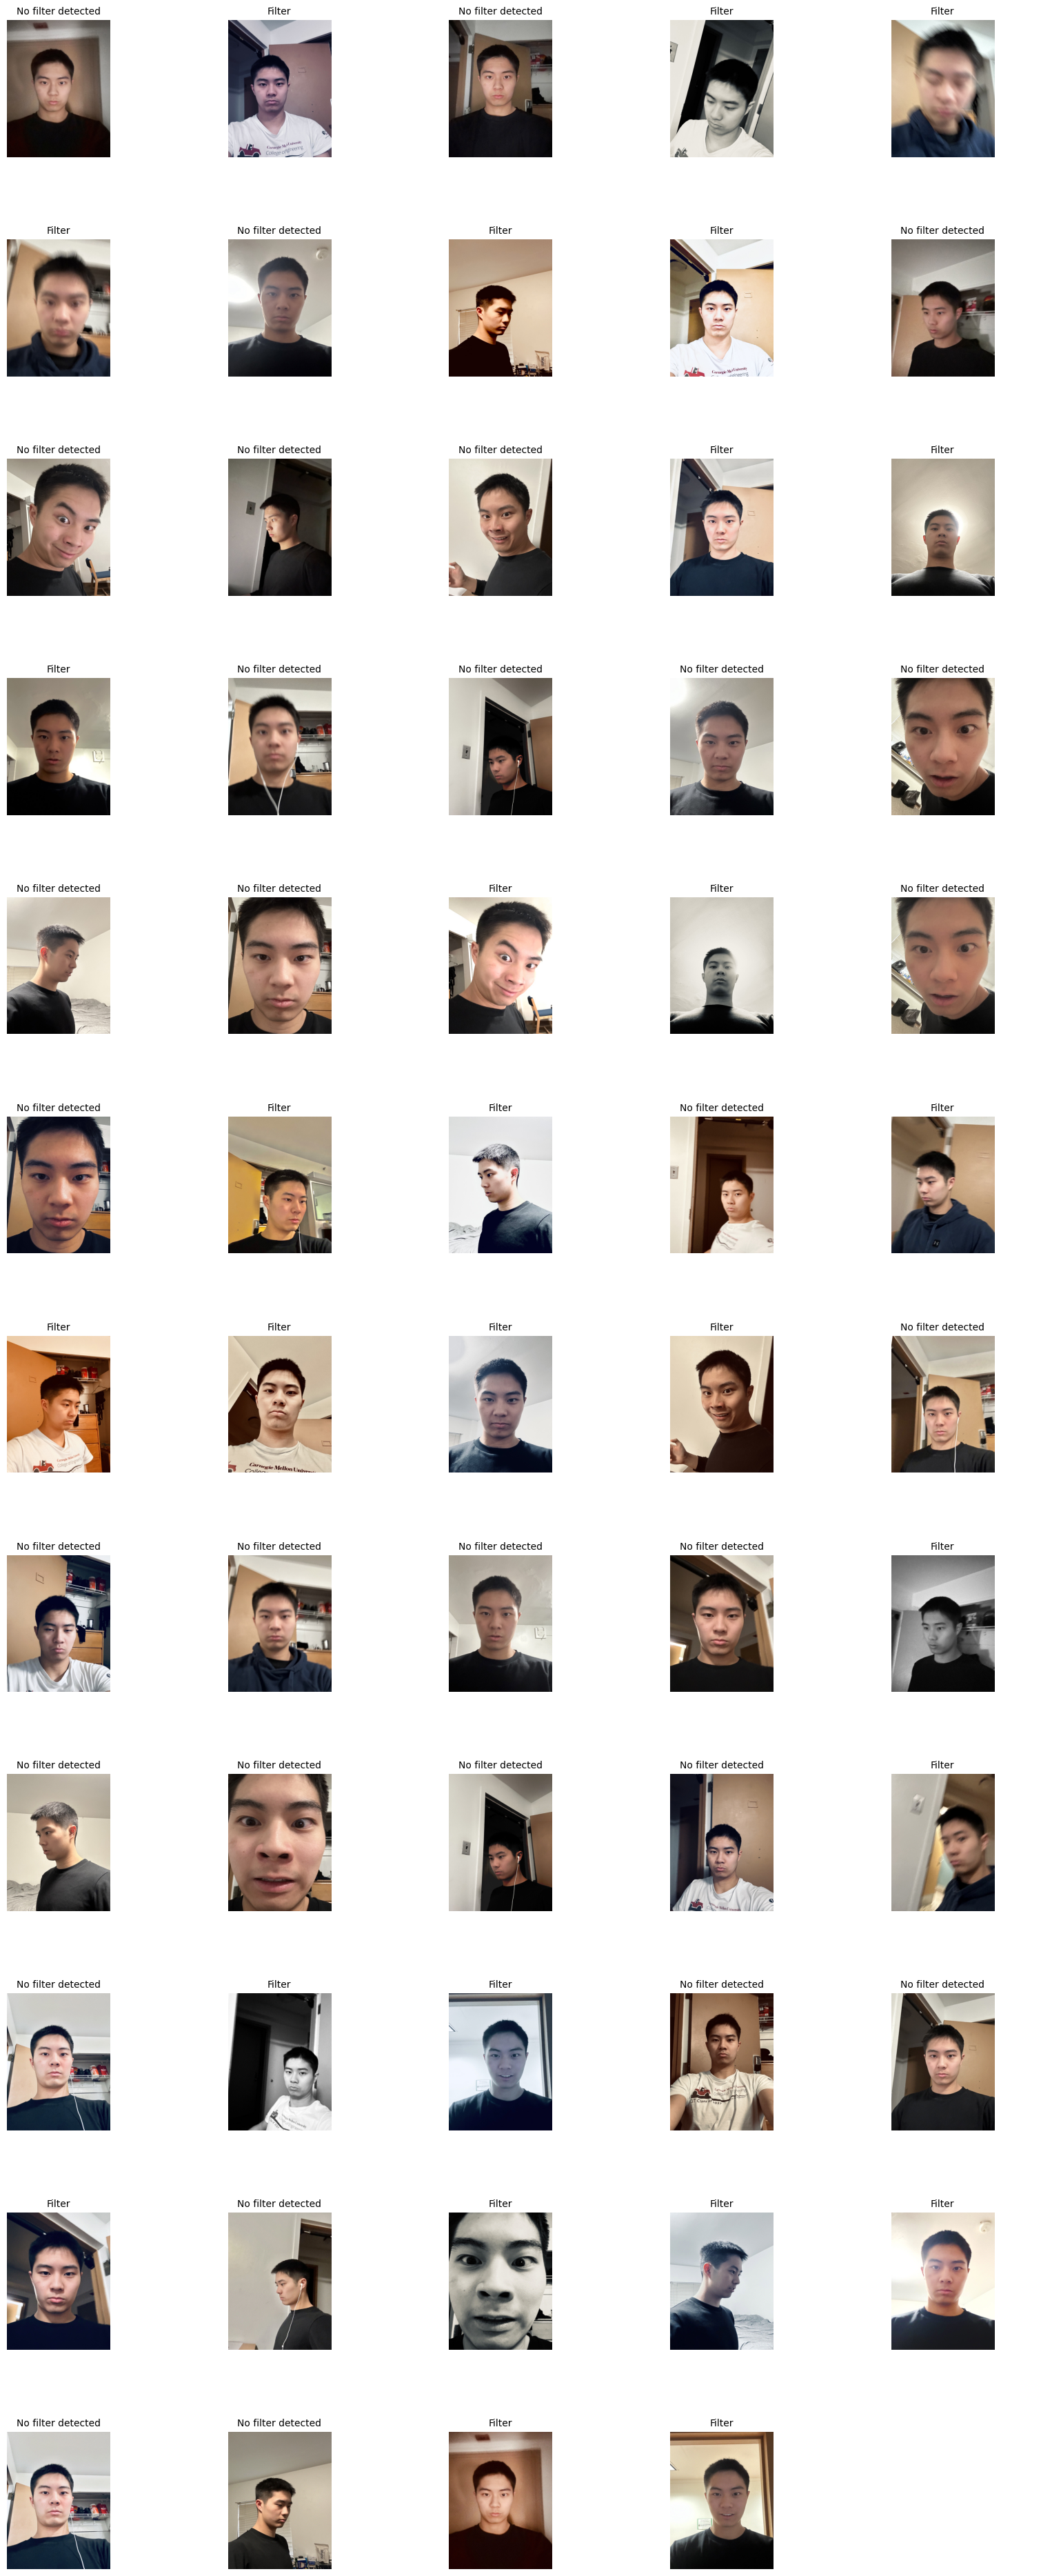

In [16]:
folder_path = 'test_final'


image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpeg')]
images_per_row = 5
num_images = len(image_files)
num_rows = num_images // images_per_row + (num_images % images_per_row > 0)
fig, axes = plt.subplots(num_rows, images_per_row, figsize=(20, num_rows * 4))
fig.subplots_adjust(hspace=0.6)

if num_rows == 1:
    axes = [axes]
    
axes = axes.flatten()
for idx, image_file in enumerate(image_files):
    img_path = os.path.join(folder_path, image_file)
    img = Image.open(img_path)
    input_tensor = transform(img)
    input_batch = input_tensor.unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')
    
    label = predict_filter(input_batch)
    # to see highest filter score for each image
    # label = predict_with_filter_scores(input_batch)
    
    axes[idx].imshow(img)
    axes[idx].set_title(label, fontsize=10)
    axes[idx].axis('off')
    
for ax in axes[idx + 1:]:
    ax.axis('off')
plt.show()

# Store predictions for each image in a list

"image_file": label

In [17]:
filtered_images = []

for idx, image_file in enumerate(image_files):
    img_path = os.path.join(folder_path, image_file)
    img = Image.open(img_path)
    input_tensor = transform(img)
    input_batch = input_tensor.unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')
    label = predict_filter(input_batch)
    
    if label == 1:
        filtered_images.append(img_path)
    
    image_label_dict[img_path] = label
    axes[idx].imshow(img)
    axes[idx].set_title(f'Label: {label}', fontsize=10)
    axes[idx].axis('off')

for img_path, label in image_label_dict.items():
    print(f'{img_path}: {label}')

NameError: name 'image_label_dict' is not defined

In [ ]:
print("Images with detected filters:")
for path in filtered_images: print(path)